# 1、特征工程

F:\python\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.draw()
F:\python\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


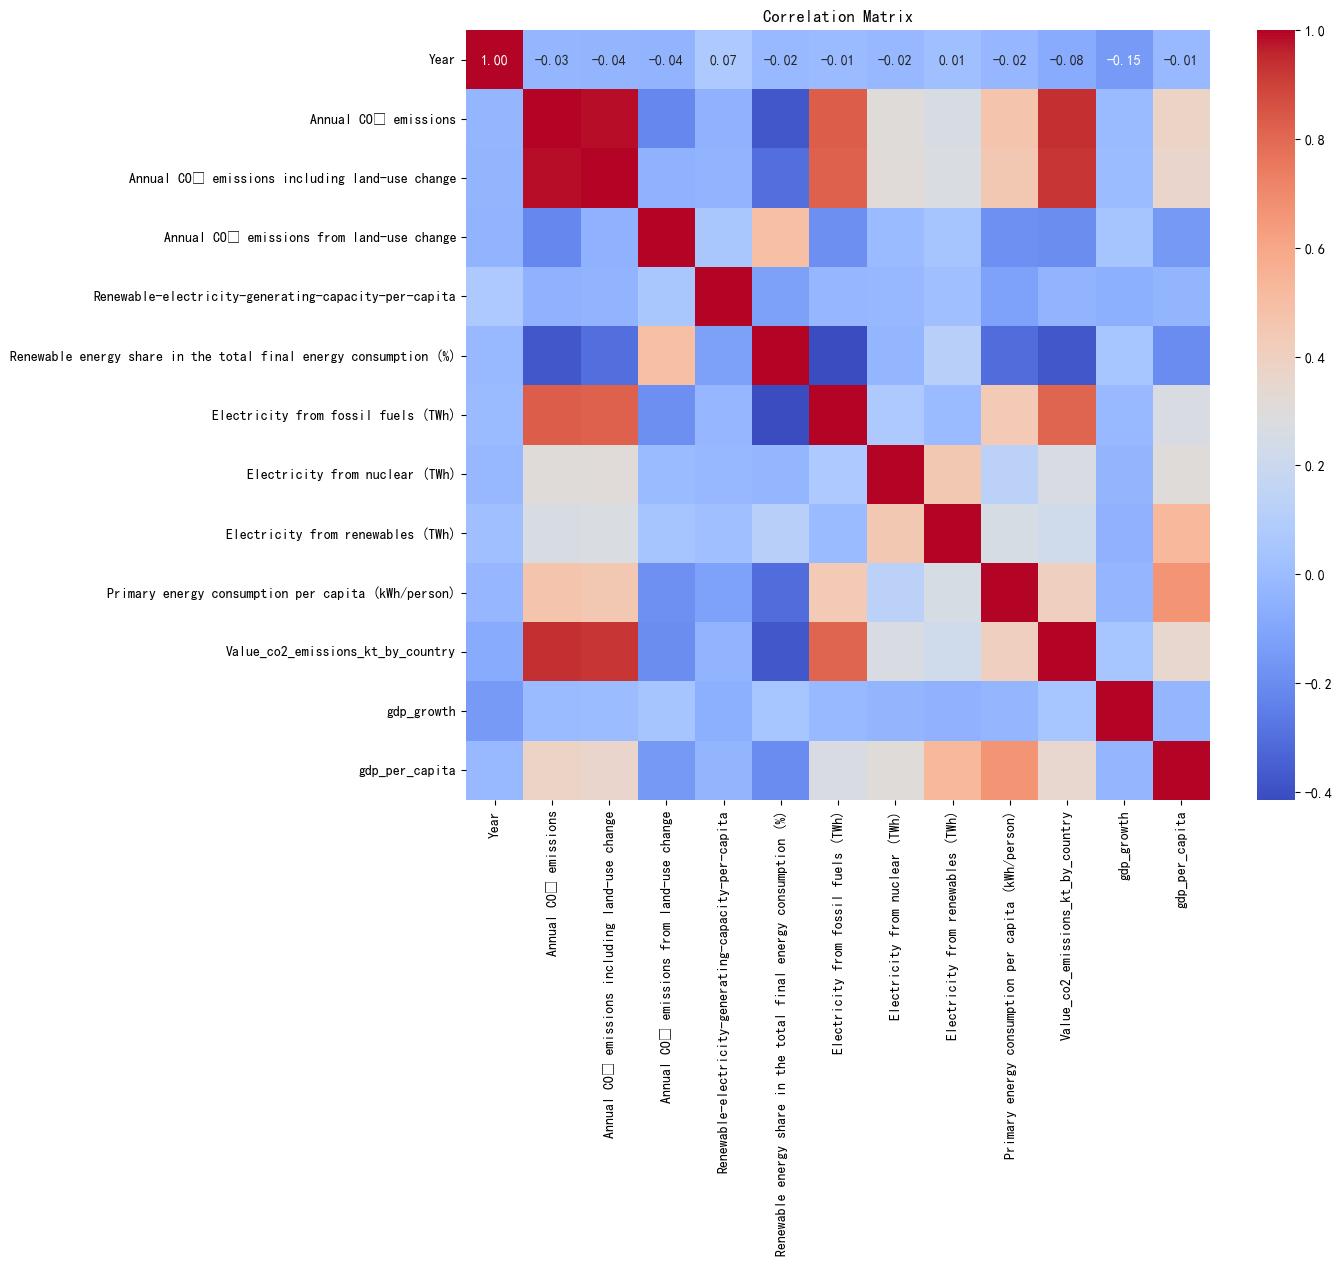

Annual CO₂ emissions                                                1.000000
Annual CO₂ emissions including land-use change                      0.985004
Value_co2_emissions_kt_by_country                                   0.938019
Electricity from fossil fuels (TWh)                                 0.833175
Primary energy consumption per capita (kWh/person)                  0.474171
gdp_per_capita                                                      0.379572
Electricity from nuclear (TWh)                                      0.308509
Electricity from renewables (TWh)                                   0.261756
gdp_growth                                                         -0.009753
Year                                                               -0.028402
Renewable-electricity-generating-capacity-per-capita               -0.047957
Annual CO₂ emissions from land-use change                          -0.217060
Renewable energy share in the total final energy consumption (%)   -0.377013

In [9]:
#1.1特征选择
#1.1.1相关性分析
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据集
filtered_data = pd.read_csv('filtered_data.csv')
newfile = pd.read_csv('newfile.csv')
newfile2 = pd.read_csv('newfile2.csv')

# 合并数据集（可以根据你项目的实际需求选择适合的方式合并数据）
data = pd.merge(filtered_data, newfile, on=['Entity', 'Year'], how='inner')

# 计算相关性矩阵
correlation_matrix = data.corr(numeric_only=True)

# 绘制相关性热图
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# 计算相关性
high_corr_features = correlation_matrix['Annual CO₂ emissions'].sort_values(ascending=False)
print(high_corr_features)

# 选择与碳排放高度相关的特征
selected_features = high_corr_features[high_corr_features > 0.4].index
data_selected = data[selected_features]


In [13]:
#1.1.2使用主成分分析进行降维
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

#数据标准化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_selected)

#PCA降维
pca = PCA(n_components=2)  #选择两个主成分
pca_result = pca.fit_transform(scaled_data)

#创建新的DataFrame存储PCA结果
df_pca = pd.DataFrame(data=pca_result,columns=['PCA1','PCA2'])
print(df_pca.head())

       PCA1      PCA2
0 -1.062831 -0.359870
1 -1.148877 -0.335971
2 -1.222522 -0.315488
3 -1.252576 -0.308737
4 -1.202541 -0.323563


In [14]:
#1.1.3 递归特征消除选择最重要的特征
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# 创建随机森林回归模型
model = RandomForestRegressor()

# 使用RFE进行特征选择
selector = RFE(model, n_features_to_select=5)
selector = selector.fit(data_selected, data['Annual CO₂ emissions'])

# 获取选择的特征
selected_features_rfe = data_selected.columns[selector.support_]
print("Selected features after RFE:", selected_features_rfe)

Selected features after RFE: Index(['Annual CO₂ emissions',
       'Annual CO₂ emissions including land-use change',
       'Value_co2_emissions_kt_by_country',
       'Electricity from fossil fuels (TWh)',
       'Primary energy consumption per capita (kWh/person)'],
      dtype='object')


In [15]:
#1.2特征构造
#1.2.1 创建时间序列特征
#根据年份信息创建时间序列特征，提取年份和月份
data['Year'] = pd.to_datetime(data['Year'],format='%Y')
data['Month'] = data['Year'].dt.month

In [16]:
#1.2.2创建交互特征-构建人均GDP和能源强度的交互特征
data['GDP_per_capita'] = newfile['gdp_per_capita']
data['Energy_intensity'] = newfile2['Energy_intensity_per_capita']

# 创建交互特征
data['GDP_Energy_Intensity'] = data['GDP_per_capita'] * data['Energy_intensity']

# 2、模型构建与训练

In [17]:
#2.1数据划分-将数据划分为训练集和测试集
from sklearn.model_selection import train_test_split

#划分数据集
X = data[selected_features_rfe]  #使用经过RFE选择的特征
y = data['Annual CO₂ emissions']  #目标变量

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [18]:
#2.2训练模型
#随机森林模型
from sklearn.ensemble import RandomForestRegressor

#随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=100,random_state=42)
rf_model.fit(X_train,y_train)

#预测与评估
y_pred_rf = rf_model.predict(X_test)

In [24]:
#支持向量机（SVM）模型
from sklearn.svm import SVR

# 支持向量机回归模型
svm_model = SVR()
svm_model.fit(X_train, y_train)

# 预测与评估
y_pred_svm = svm_model.predict(X_test)

In [25]:
#时间序列模型
from statsmodels.tsa.arima.model import ARIMA

# 使用ARIMA模型进行时间序列预测
model_arima = ARIMA(y_train, order=(5, 1, 0))  # 选择合适的参数
model_arima_fit = model_arima.fit()

# 预测
y_pred_arima = model_arima_fit.forecast(steps=len(y_test))

F:\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [29]:
#2.3模型评估
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 随机森林评估
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
# 计算 MSE，再计算 RMSE
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("Random Forest RMSE:", rmse_rf)
print("Random Forest R^2:", r2_score(y_test, y_pred_rf))

# 支持向量机评估
print("SVM MAE:", mean_absolute_error(y_test, y_pred_svm))
# 计算 MSE，再计算 RMSE
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
print("SVM RMSE:", rmse_svm)
print("SVM R^2:", r2_score(y_test, y_pred_svm))

# ARIMA评估
print("ARIMA MAE:", mean_absolute_error(y_test, y_pred_arima))
# 计算 MSE，再计算 RMSE
mse_arima = mean_squared_error(y_test, y_pred_arima)
rmse_arima = np.sqrt(mse_arima)
print("ARIMA RMSE:", rmse_arima)


Random Forest MAE: 167457.2537304347
Random Forest RMSE: 650579.4305269747
Random Forest R^2: 0.9993393164584987
SVM MAE: 18283646.96022699
SVM RMSE: 28391250.000333454
SVM R^2: -0.25823528462820144
ARIMA MAE: 25120543.82428425
ARIMA RMSE: 28536532.495093916


# 3、可视化分析

F:\python\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


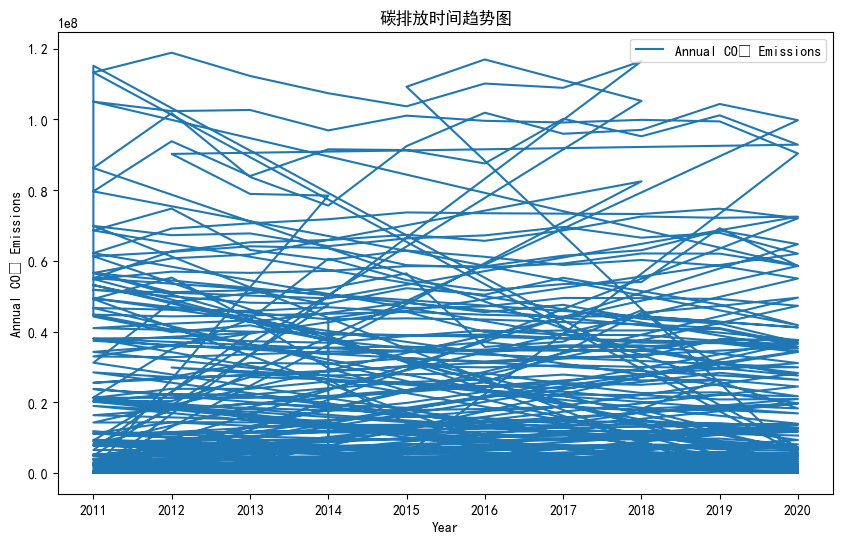

In [30]:
#3.1 使用Matplotlib绘制碳排放的时间趋势图

plt.rcParams['font.family']='SimHei'        # 设置使用黑体字体以正常显示中文
plt.rcParams['axes.unicode_minus']=False   # 正常显示负号

plt.figure(figsize=(10, 6))
plt.plot(data['Year'], data['Annual CO₂ emissions'], label='Annual CO₂ Emissions')
plt.xlabel('Year')
plt.ylabel('Annual CO₂ Emissions')
plt.title('碳排放时间趋势图')
plt.legend()
plt.show()

In [36]:
print(data['Year'].dtype)

int64


In [38]:
#3.2 通过Plotly绘制碳排放和人均GDP之间的关系图

# 确保'Year'是整数类型
data['Year'] = data['Year'].astype(int)

import plotly.express as px

# 绘制碳排放和人均GDP之间的关系图
fig = px.scatter(data, x='GDP_per_capita', y='Annual CO₂ emissions', color='Year', title="Carbon Emission vs Per Capita GDP")
fig.show()


In [40]:
!pip install dash

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
     ---------------------------------------- 0.1/7.9 MB 656.4 kB/s eta 0:00:12
      --------------------------------------- 0.1/7.9 MB 1.1 MB/s eta 0:00:08
      --------------------------------------- 0.1/7.9 MB 1.1 MB/s eta 0:00:08
     - -------------------------------------- 0.2/7.9 MB 1.0 MB/s eta 0:00:08
     - -------------------------------------- 0.3/7.9 MB 1.1 MB/s eta 0:00:07
     -- ------------------------------------- 0.5/7.9 MB 1.5 MB/s eta 0:00:06
     -- ------------------------------------- 0.5/7.9 MB 1.3 MB/s eta 0:00:06
     -- ------------------------------------- 0.6/7.9 MB 1.4 MB/s eta 0:00:06
     -- ------------------------------------- 0.6/7.9 MB 1.4 MB/s eta 0:00:06
     -- ------------------------------------- 0.6/7.9 MB 1.4 MB/s eta 0:00:06
     ---- -----

In [45]:
#3.3 构建Dash可视化面板
import dash
from dash import dcc, html
import plotly.graph_objs as go

# 创建Dash应用
app = dash.Dash(__name__)

# 创建图表
trace = go.Scatter(x=data['Year'], y=data['Annual CO₂ emissions'], mode='lines', name='CO₂ Emissions')
layout = go.Layout(title='Carbon Emission Trend', xaxis=dict(title='Year'), yaxis=dict(title='CO₂ Emissions'))
fig = go.Figure(data=[trace], layout=layout)

# Dash布局
app.layout = html.Div([
    dcc.Graph(figure=fig),
    html.H1("Carbon Emission Visualization")
])

# 运行Dash应用
if __name__ == '__main__':
    app.run(debug=True)
